In [1]:
import os
import utils

utils.load_env()
os.environ['LANGCHAIN_TRACING_V2'] = "false"

In [2]:
from langchain_core.messages import HumanMessage
import operator
import functools

# for llm model
from langchain_openai import ChatOpenAI
from langchain.agents.format_scratchpad import format_to_openai_function_messages
from tools import find_place_from_text, nearby_search
from typing import Dict, List, Tuple, Annotated, Sequence, TypedDict
from langchain.agents import (
    AgentExecutor,
)
from langchain.agents.output_parsers import OpenAIFunctionsAgentOutputParser
from langchain_community.chat_models import ChatOpenAI
from langchain_community.tools.convert_to_openai import format_tool_to_openai_function
from langchain_core.messages import (
    AIMessage, 
    HumanMessage,
    BaseMessage,
    ToolMessage
)
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import END, StateGraph, START

## Document vector store for context
from langchain_core.runnables import RunnablePassthrough
from langchain_chroma import Chroma
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import CSVLoader
from langchain_openai import OpenAIEmbeddings
import glob
from langchain.tools import Tool

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Specify the pattern
file_pattern = "document/*.csv"
file_paths = tuple(glob.glob(file_pattern))

all_docs = []

for file_path in file_paths:
    loader = CSVLoader(file_path=file_path)
    docs = loader.load()
    all_docs.extend(docs)  # Add the documents to the list

# Split text into chunks separated.
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=100)
splits = text_splitter.split_documents(all_docs)

# Text Vectorization.
vectorstore = Chroma.from_documents(documents=splits, embedding=OpenAIEmbeddings())

# Retrieve and generate using the relevant snippets of the blog.
retriever = vectorstore.as_retriever()

## tools and LLM

retriever_tool = Tool(
    name="Retriever",
    func=retriever.get_relevant_documents,
    description="Use this tool to retrieve information about population, community and household expenditures."
)

# Bind the tools to the model
tools = [retriever_tool, find_place_from_text, nearby_search]  # Include both tools if needed

llm = ChatOpenAI(model="gpt-4o-mini")

## Create agents
def create_agent(llm, tools, system_message: str):
    """Create an agent."""
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to progress towards answering the question."
                " If you are unable to fully answer, that's OK, another assistant with different tools "
                " will help where you left off. Execute what you can to make progress."
                " If you or any of the other assistants have the final answer or deliverable,"
                " prefix your response with FINAL ANSWER so the team knows to stop."
                " You have access to the following tools: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    llm_with_tools = llm.bind(functions=[format_tool_to_openai_function(t) for t in tools])
    # return prompt | llm.bind_tools(tools)
    agent = prompt | llm_with_tools
    return agent


## Define state
# This defines the object that is passed between each node
# in the graph. We will create different nodes for each agent and tool
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str


# Helper function to create a node for a given agent
def agent_node(state, agent, name):
    result = agent.invoke(state)
    # We convert the agent output into a format that is suitable to append to the global state
    if isinstance(result, ToolMessage):
        pass
    else:
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
    return {
        "messages": [result],
        # Since we have a strict workflow, we can
        # track the sender so we know who to pass to next.
        "sender": name,
    }


## Define Agents Node
# Research agent and node
agent_meta = utils.load_agent_meta()
agent_name = [meta['name'] for meta in agent_meta]

agents={}
agent_nodes={}

for meta in agent_meta:
    name = meta['name']
    prompt = meta['prompt']
    
    agents[name] = create_agent(
            llm,
            [find_place_from_text, nearby_search],
            system_message=prompt,
        )
    
    agent_nodes[name] = functools.partial(agent_node, agent=agents[name], name=name)


## Define Tool Node
from langgraph.prebuilt import ToolNode
from typing import Literal

tool_node = ToolNode(tools)

def router(state) -> Literal["call_tool", "__end__", "continue"]:
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        # The previous agent is invoking a tool
        return "call_tool"
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return "__end__"
    return "continue"


## Workflow Graph
workflow = StateGraph(AgentState)

# add agent nodes
for name, node in agent_nodes.items():
    workflow.add_node(name, node)
    
workflow.add_node("call_tool", tool_node)


for meta in agent_meta:
    workflow.add_conditional_edges(
        meta["name"],
        router,
        {"continue": meta['continue'], "call_tool": "call_tool", "__end__": END},
    )

workflow.add_conditional_edges(
    "call_tool",
    # Each agent node updates the 'sender' field
    # the tool calling node does not, meaning
    # this edge will route back to the original agent
    # who invoked the tool
    lambda x: x["sender"],
    {name: name for name in agent_name},
)
workflow.add_edge(START, "analyst")
graph = workflow.compile()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:141: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 0.3.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import ChatOpenAI`.
  warn_deprecated(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:141: LangChainDeprecationWarning: The function `format_tool_to_openai_function` was deprecated in LangChain 0.1.16 and will be removed in 1.0. Use langchain_core.utils.function_calling.convert_to_openai_function() instead.
  warn_deprecated(


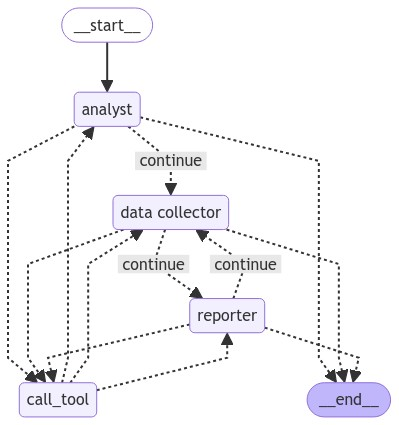

In [3]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [4]:
graph = workflow.compile()

events = graph.stream(
    {
        "messages": [
            HumanMessage(
                content="ค้นหาร้านกาแฟใกล้มาบุญครอง"
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 10},
)
for s in events:
    print(s)
    print("----")

{'analyst': {'messages': [AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"location":"มาบุญครอง"}', 'name': 'find_place_from_text'}}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 329, 'total_tokens': 350}, 'model_name': 'gpt-4o-mini', 'system_fingerprint': 'fp_48196bc67a', 'finish_reason': 'function_call', 'logprobs': None}, name='analyst', id='run-e6c09af4-41ab-441b-b471-751510f63096-0')], 'sender': 'analyst'}}
----
{'data collector': {'messages': [AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"input_dict":{"keyword":"ร้านกาแฟ","location_name":"มาบุญครอง","radius":1000,"place_type":"cafe"}}', 'name': 'nearby_search'}}, response_metadata={'token_usage': {'completion_tokens': 42, 'prompt_tokens': 326, 'total_tokens': 368}, 'model_name': 'gpt-4o-mini', 'system_fingerprint': 'fp_48196bc67a', 'finish_reason': 'function_call', 'logprobs': None}, name='data collector', id='run-19518aa2-3c77-46bd-a35a-76e871

In [6]:
def submitUserMessage(user_input: str) -> str:
    graph = workflow.compile()

    events = graph.stream(
        {
            "messages": [
                HumanMessage(
                    content=user_input
                )
            ],
        },
        # Maximum number of steps to take in the graph
        {"recursion_limit": 15},
    )
    
    events = [e for e in events]
    
    response = events[-1]['data collector']['messages'][0].content.replace("FINAL ANSWER: ", "")
    
    return response

submitUserMessage("ค้นหาร้านกาแฟใกล้มาบุญครอง")

'รายชื่อร้านกาแฟใกล้มาบุญครอง ได้แก่:\n\n1. **ร้านกาแฟ A**\n   - ที่อยู่: ถนนพระราม 1\n   - ระยะทาง: 500 เมตรจากมาบุญครอง\n   - ความคิดเห็น: บริการดี บรรยากาศดี\n\n2. **ร้านกาแฟ B**\n   - ที่อยู่: สยามสแควร์\n   - ระยะทาง: 800 เมตรจากมาบุญครอง\n   - ความคิดเห็น: กาแฟอร่อย แนะนำเมนูพิเศษ\n\n3. **ร้านกาแฟ C**\n   - ที่อยู่: สวนลุมพินี\n   - ระยะทาง: 1.5 กม.จากมาบุญครอง\n   - ความคิดเห็น: มีมุมสงบ เหมาะสำหรับอ่านหนังสือ\n\n4. **ร้านกาแฟ D**\n   - ที่อยู่: ถนนสีลม\n   - ระยะทาง: 2 กม.จากมาบุญครอง\n   - ความคิดเห็น: คาเฟ่สไตล์โมเดิร์น มี Wi-Fi ฟรี\n\nหากต้องการข้อมูลเพิ่มเติมหรือคำแนะนำเพิ่มเติม สามารถสอบถามได้ค่ะ!'